In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.orbits.keplerian import System, Central
from jaxoplanet.light_curves import limb_dark_light_curve
from jaxoplanet.starry.visualization import show_surface
from jaxoplanet.starry.surface import Surface
from jaxoplanet.starry.orbit import SurfaceSystem
from jaxoplanet.starry.light_curves import surface_light_curve
from jaxoplanet.starry.light_curves import light_curve as starry_lc
from jaxoplanet.starry.ylm import Ylm
import jax.numpy as jnp
from astropy import units as u
from astropy import constants as const
from Phase_curve_v1 import phase_curve, phase_angle, luminosity_bb, phase_planet
from Phase_curve_TTV import phase_TTV
from Orbital_motion import compute_true_anomaly
from Transits import eclipse
from Solar_System_constants import R_Earth, R_Sun


In [4]:
def fast_binning(x, y, bins, error=None, std=False):
    bins = np.arange(np.min(x), np.max(x), bins)
    d = np.digitize(x, bins)

    n = np.max(d) + 2

    binned_x = np.empty(n)
    binned_y = np.empty(n)
    binned_error = np.empty(n)

    binned_x[:] = -np.pi
    binned_y[:] = -np.pi
    binned_error[:] = -np.pi

    for i in range(0, n):
        s = np.where(d == i)
        if len(s[0]) > 0:
            s = s[0]
            binned_y[i] = np.mean(y[s])
            binned_x[i] = np.mean(x[s])
            binned_error[i] = np.std(y[s]) / np.sqrt(len(s))

            if error is not None:
                err = error[s]
                binned_error[i] = np.sqrt(np.sum(np.power(err, 2))) / len(err)
            else:
                binned_error[i] = np.std(y[s]) / np.sqrt(len(s))

    nans = binned_x == -np.pi
    
    return binned_x[~nans], binned_y[~nans], binned_error[~nans]

{'planet_radius': np.float64(1.300241765), 'star_temperature': np.float64(3036.0), 'star_radius': np.float64(0.19), 'sma': np.float64(930498755.8), 'star_logg': np.float64(5.06), 'a/Rs': np.float64(7.039473728089088), 'Rp/Rs': np.float64(0.06273932352380034), 'albedo': 0.0, 'hrf': 0.6666666666666666, 'pos': 0.0, 'inclination': np.float64(88.5), 'mid_time': 2460000, 'eccentricity': 0.0, 'periastron': 0.0, 'period': np.float64(0.46292964), 'dayside_temperature': 1033, 'equilibrium_temperature': 809, 'nightside_temperature': 50, 'phase_curve_offset': 0.0}


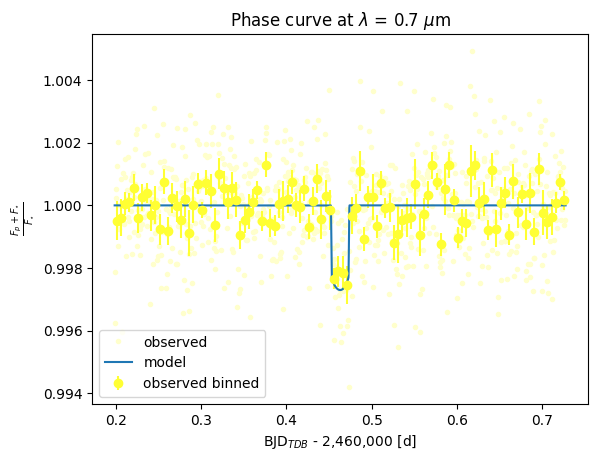

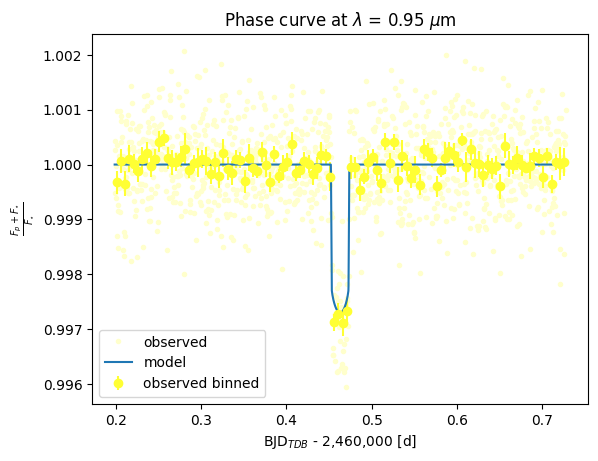

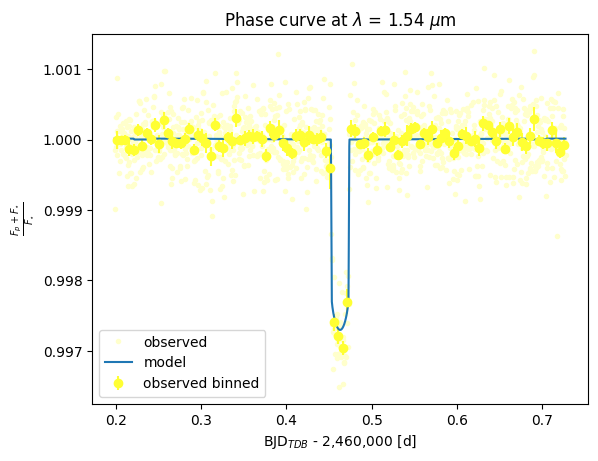

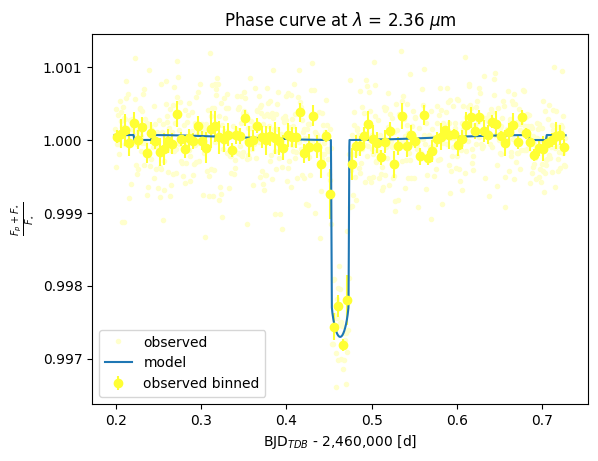

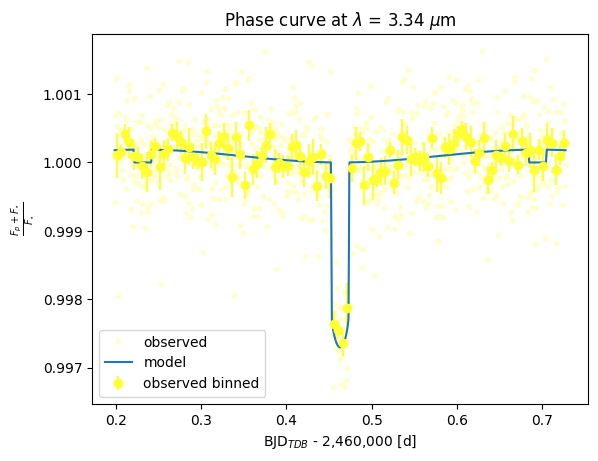

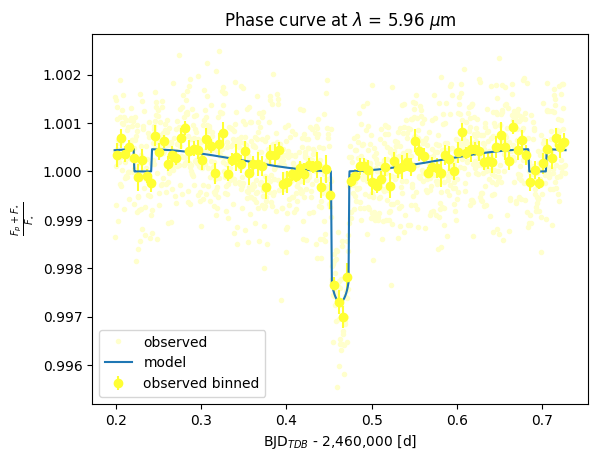

In [5]:
df = pd.read_pickle("LHS3844b_0.0_1obs.pickle")

print(df['input_parameters'])
data = df['input_parameters']

wvl = df['data'].keys()

for lamb in wvl:
    model_time = df['data'][lamb]['model']['time'] - 2460000
    model_phase = df['data'][lamb]['model']['phase']
    model_pc = df['data'][lamb]['model']['pc']
    observed_time = df['data'][lamb]['observed']['time'] - 2460000
    observed_phase = df['data'][lamb]['observed']['phase']
    observed_pc = df['data'][lamb]['observed']['pc']
    observed_binned = fast_binning(observed_time, observed_pc, 0.005)

    plt.figure()
    plt.plot(observed_time, observed_pc, '.', c=(1, 1, 0.8), label='observed')
    plt.errorbar(observed_binned[0], observed_binned[1], yerr=observed_binned[2], fmt='o', c=(1, 1, 0.2), label='observed binned')
    plt.plot(model_time, model_pc, label='model')
    plt.title(rf'Phase curve at $\lambda$ = {lamb} $\mu$m')
    plt.legend()
    plt.xlabel(r'BJD$_{TDB}$ - 2,460,000 [d]')
    plt.ylabel(r'$\frac{F_p + F_{\star}}{F_{\star}}$')
    plt.show()

<class 'dict'>
5
dict_keys(['datasets', 'pl_type', 'parameters', 'theta', 'num_obs'])
{'Rs': {'index': 0}, 'Ts': {'index': 1}, 'Ms': {'index': 2}, 'P': {'index': 3}, 'T0': {'index': 4}, 'i': {'index': 5}, 'Rp/Rs': {'index': 6}, 'HSO': {'index': 7}, 'Td': {'index': 8}, 'Tn': {'index': 9}, 'A_g': {'index': 10}}
max
[1.89000000e-01 3.03600000e+03 1.51000000e-01 4.62929640e-01
 2.45882893e+06 8.85000000e+01 6.35000000e-02 0.00000000e+00
 1.03124762e+03 5.00000000e+01 0.00000000e+00]
1
{'exp_time': np.float64(60.0), 'min_wl': np.float64(0.5), 'max_wl': np.float64(0.6000000000000001), 'dead_time': 0.2, 'model_time': 900.0, 'lc':              time     phase  ref_pc      therm_pc  transit  model  flux_error  \
0    2.458829e+06  1.727774     0.0  2.389529e-10      0.0    1.0     0.00621   
1    2.458829e+06  1.737231     0.0  2.408817e-10      0.0    1.0     0.00621   
2    2.458829e+06  1.746688     0.0  2.428073e-10      0.0    1.0     0.00621   
3    2.458829e+06  1.756145     0.0  2.447298

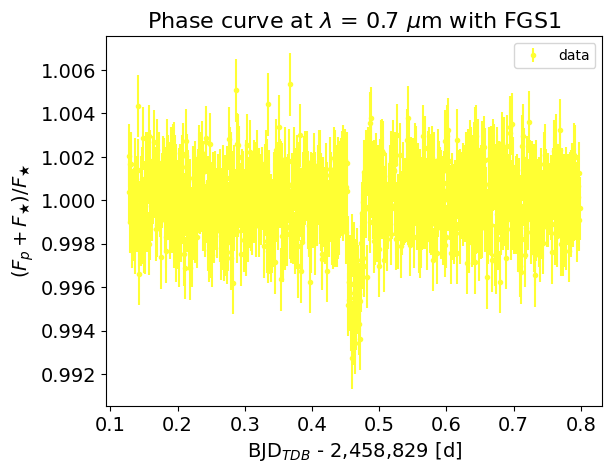

[0.00069674 0.00069674 0.00069674 ... 0.00069674 0.00069674 0.00069674]
[0.00014528 0.00014855 0.00014855 0.00014855 0.00014855 0.00014855
 0.00014855 0.00014528 0.00014855 0.00014855 0.00014855 0.00014855
 0.00014855 0.00014855 0.00014855 0.00014528 0.00014855 0.00014855
 0.00014855 0.00014855 0.00014855 0.00014855 0.00014528 0.00014855
 0.00014855 0.00014855 0.00014855 0.00014855 0.00014855 0.00014855
 0.00014528 0.00014855 0.00014855 0.00014855 0.00014855 0.00014855
 0.00014855 0.00014855 0.00014528 0.00014855 0.00014855 0.00014855
 0.00014855 0.00014855 0.00014855 0.00014528 0.00014855 0.00014855
 0.00014855 0.00014855 0.00014855 0.00014855 0.00014855 0.00014528
 0.00014855 0.00014855 0.00014855 0.00014855 0.00014855 0.00014855
 0.00014855 0.00014528 0.00014855 0.00014855 0.00014855 0.00014855
 0.00014855 0.00040226]


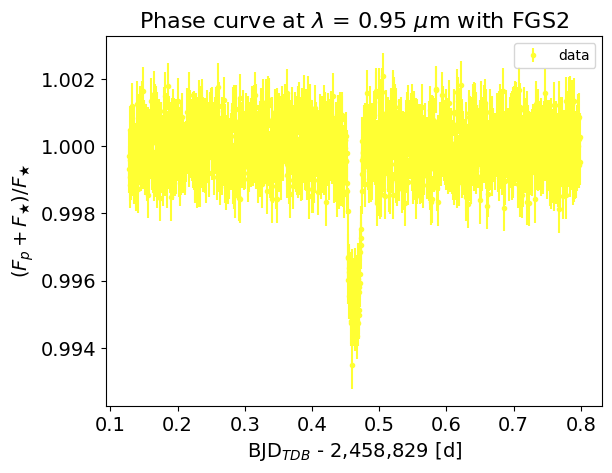

[0.00034784 0.00034784 0.00034784 ... 0.00034784 0.00034784 0.00034784]
[7.25293192e-05 7.41593951e-05 7.41593951e-05 7.41593951e-05
 7.41593951e-05 7.41593951e-05 7.41593951e-05 7.25293192e-05
 7.41593951e-05 7.41593951e-05 7.41593951e-05 7.41593951e-05
 7.41593951e-05 7.41593951e-05 7.41593951e-05 7.25293192e-05
 7.41593951e-05 7.41593951e-05 7.41593951e-05 7.41593951e-05
 7.41593951e-05 7.41593951e-05 7.25293192e-05 7.41593951e-05
 7.41593951e-05 7.41593951e-05 7.41593951e-05 7.41593951e-05
 7.41593951e-05 7.41593951e-05 7.25293192e-05 7.41593951e-05
 7.41593951e-05 7.41593951e-05 7.41593951e-05 7.41593951e-05
 7.41593951e-05 7.41593951e-05 7.25293192e-05 7.41593951e-05
 7.41593951e-05 7.41593951e-05 7.41593951e-05 7.41593951e-05
 7.41593951e-05 7.25293192e-05 7.41593951e-05 7.41593951e-05
 7.41593951e-05 7.41593951e-05 7.41593951e-05 7.41593951e-05
 7.41593951e-05 7.25293192e-05 7.41593951e-05 7.41593951e-05
 7.41593951e-05 7.41593951e-05 7.41593951e-05 7.41593951e-05
 7.41593951e-

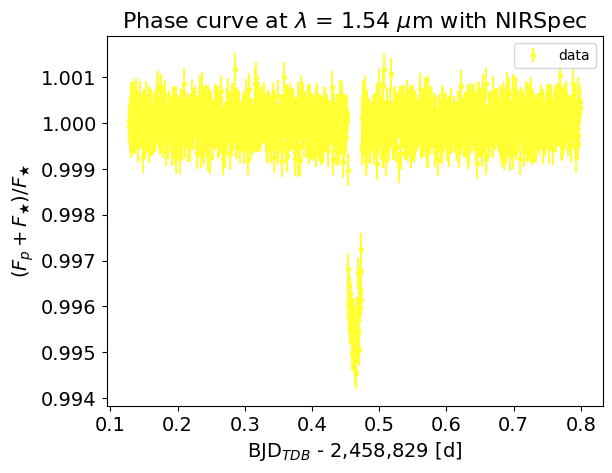

[0.00043567 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567
 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567
 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567
 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567
 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567
 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567
 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567
 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567
 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567
 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567
 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567
 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567
 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567
 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567
 0.00043567 0.00043567 0.00043567 0.00043567 0.00043567 0.0004

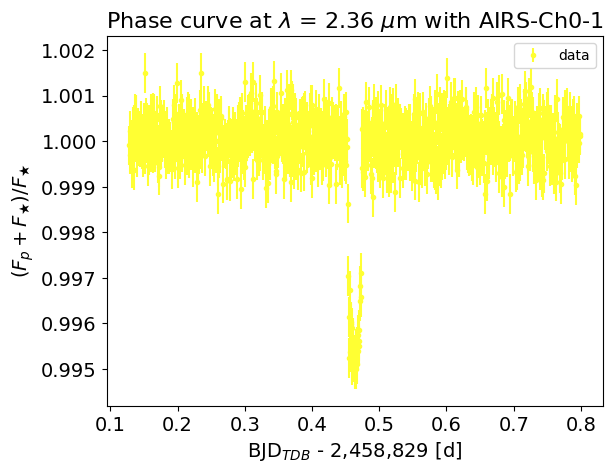

[0.00058401 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401
 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401
 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401
 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401
 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401
 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401
 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401
 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401
 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401
 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401
 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401
 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401
 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401
 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401
 0.00058401 0.00058401 0.00058401 0.00058401 0.00058401 0.0005

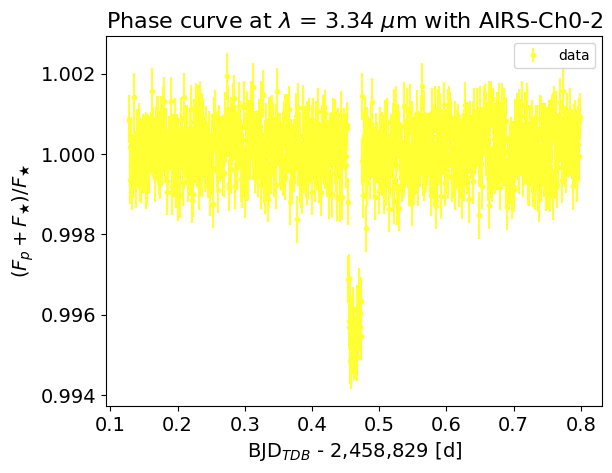

[0.0007194 0.0007194 0.0007194 ... 0.0007194 0.0007194 0.0007194]
[0.00014388 0.00014685 0.00014685 0.00014685 0.00014685 0.00014685
 0.00014685 0.00014685 0.00014685 0.00014685 0.00014388 0.00014685
 0.00014685 0.00014685 0.00014685 0.00014685 0.00014685 0.00014685
 0.00014685 0.00014685 0.00014388 0.00014685 0.00014685 0.00014685
 0.00014685 0.00014685 0.00014685 0.00014685 0.00014685 0.00014685
 0.00014388 0.00014685 0.00014685 0.00014685 0.00014685 0.00014685
 0.00014685 0.00014685 0.00014685 0.00014685 0.00014388 0.00014685
 0.00014685 0.00014685 0.00014685 0.00014685 0.00014685 0.00014685
 0.00014685 0.00014685 0.00014388 0.00014685 0.00014685 0.00014685
 0.00014685 0.00014685 0.00014685 0.00014685 0.00014685 0.00014685
 0.00014388 0.00014685 0.00014685 0.00014685 0.00014685 0.00014685
 0.00014685 0.00041535]


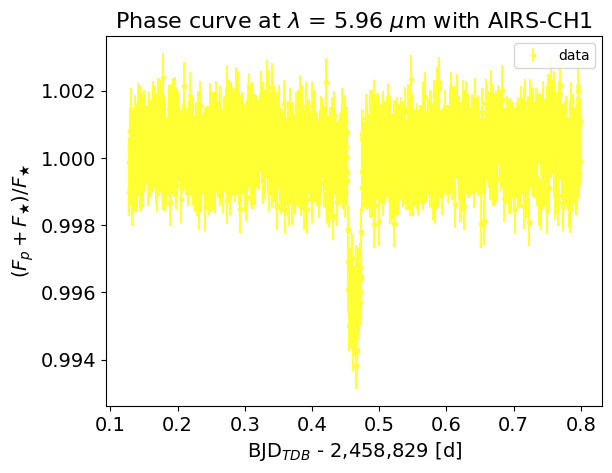

In [ ]:


#df = pd.read_pickle("LHS3844b_0.0_1obs.pickle")
df2 = pd.read_pickle("LHS3844b_phase_curve_max_1obs.pickle")

#print(df) 
print(type(df2))
print(len(df2))
print(df2.keys())
print(df2['parameters'])
print(df2['pl_type'])
print(df2['theta'])
print(df2['num_obs'])
print(df2['datasets'][b'VISPhot'])
#print(df['input_parameters'])
print(df2['datasets'][b'VISPhot']['lc'])#['lc'])
#print(df['data'].keys())


time_2 = df2['datasets'][b'VISPhot']['lc']['time'] - 2458828.93
pc_2 = df2['datasets'][b'VISPhot']['lc']['model'] #+ df2['datasets'][b'VISPhot']['lc']['therm_pc']

instru = df2['datasets'].keys()
print(instru)
instru = list(instru)
instru.pop(0)

plt.rcParams.update({
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
})

for i, inst in enumerate(instru) : 
    time = df2['datasets'][inst]['lc']['time'] - 2458828.93
    pc = df2['datasets'][inst]['lc']['model']
    second_binned = fast_binning(time, df2['datasets'][inst]['lc']['ariel'], 0.01, error = np.array(df2['datasets'][inst]['lc']['flux_error']))
    plt.figure()
    plt.errorbar(time, df2['datasets'][inst]['lc']['ariel'], yerr=df2['datasets'][inst]['lc']['flux_error'], c=(1, 1, 0.2), fmt='.', label='data')
    plt.errorbar(second_binned[0], second_binned[1], yerr=df2['datasets'][inst]['lc']['flux_error'][:len(second_binned[0])], c=(1, 0.5, 0), fmt='o', label='observed binned', zorder=10)
    print(np.array(df2['datasets'][inst]['lc']['flux_error']))
    print(second_binned[2])
    #plt.plot(time, pc, label='model')
    #plt.plot(model_time, model_pc, label='model')
    plt.title(rf'Phase curve at $\lambda$ = {list(wvl)[i]} $\mu$m with {str(inst)[2:-1]}', fontsize=16)
    plt.legend()
    plt.xlabel(r'BJD$_{TDB}$ - 2,458,829 [d]', fontsize=14)
    plt.ylabel(r'$(F_p + F_{\bigstar})/F_{\bigstar}$', fontsize=14)
    plt.savefig(f"data_{str(inst)[2:-1]}.svg")
    plt.show()


In [2]:
4.62929640e-01 * 24

11.110311359999999

In [ ]:
df2 = pd.read_pickle("LHS3844b_phase_curve_max_1obs.pickle")
print(df2['parameters'])
print(df2['theta'])
print(df['input_parameters'])

{'Rs': {'index': 0}, 'Ts': {'index': 1}, 'Ms': {'index': 2}, 'P': {'index': 3}, 'T0': {'index': 4}, 'i': {'index': 5}, 'Rp/Rs': {'index': 6}, 'HSO': {'index': 7}, 'Td': {'index': 8}, 'Tn': {'index': 9}, 'A_g': {'index': 10}}
[1.89000000e-01 3.03600000e+03 1.51000000e-01 4.62929640e-01
 2.45882893e+06 8.85000000e+01 6.35000000e-02 0.00000000e+00
 1.03124762e+03 5.00000000e+01 0.00000000e+00]
{'planet_radius': np.float64(1.300241765), 'star_temperature': np.float64(3036.0), 'star_radius': np.float64(0.19), 'sma': np.float64(930498755.8), 'star_logg': np.float64(5.06), 'a/Rs': np.float64(7.039473728089088), 'Rp/Rs': np.float64(0.06273932352380034), 'albedo': 0.0, 'hrf': 0.6666666666666666, 'pos': 0.0, 'inclination': np.float64(88.5), 'mid_time': 2460000, 'eccentricity': 0.0, 'periastron': 0.0, 'period': np.float64(0.46292964), 'dayside_temperature': 1033, 'equilibrium_temperature': 809, 'nightside_temperature': 50, 'phase_curve_offset': 0.0}


In [ ]:
transit_duration_days = 0.5212/24
P=df2['theta'][3]
#time_transit=df2['theta'][4] #2458828.93037
impact_param=0.186
R_star = df2['theta'][0]*R_Sun
time_transit = 0
e = 0.0
omega = 0.0 # bcs e = 0
i = df2['theta'][5]*np.pi/180
a = 0.00622*149597870700 # a in m
#R = data['planet_radius']*R_Earth
R = df2['theta'][6]*R_star
lambda_1 = 5.8
lambda_2 = 6.1
T_star = df2['theta'][1]
L_star = luminosity_bb(T_star, lambda_1, lambda_2)
T_planet = df2['theta'][8]
L = luminosity_bb(T_planet, lambda_1, lambda_2)
print(R/R_star)

0.0635


In [ ]:
orbit = TransitOrbit(
    period=P, duration=transit_duration_days, time_transit=time_transit, impact_param=impact_param, radius_ratio=df2['theta'][6])

# Compute a limb-darkened light curve for this orbit
time = df['data'][lamb]['model']['time'] - 2460000
uu = [0.1, 0.06]  # Quadratic limb-darkening coefficients
light_curve = limb_dark_light_curve(orbit, uu)(time)

Central(
  mass=np.float64(0.151),
  radius=np.float64(0.1891744113842173),
  density=np.float64(5.3247738074303275)
)
OrbitalBody(
  central=Central(
    mass=np.float64(0.151),
    radius=np.float64(0.1891744113842173),
    density=np.float64(5.3247738074303275)
  ),
  time_ref=f32[],
  time_transit=0.0,
  period=np.float64(0.46292964),
  semimajor=f32[],
  sin_inclination=f32[],
  cos_inclination=f32[],
  impact_param=f32[],
  mass=None,
  radius=np.float64(0.0120125751228978),
  eccentricity=None,
  sin_omega_peri=None,
  cos_omega_peri=None,
  sin_asc_node=None,
  cos_asc_node=None,
  radial_velocity_semiamplitude=None,
  parallax=None
)


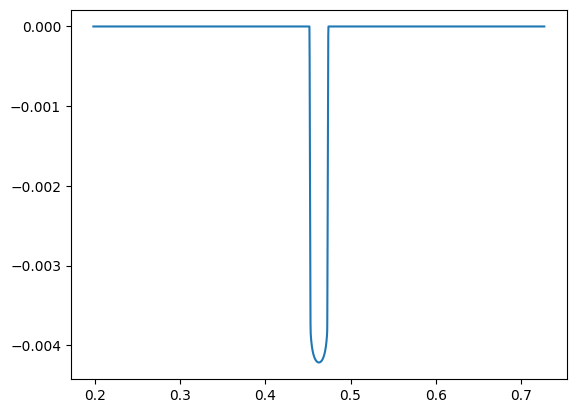

In [ ]:
star = Central(radius=(R_star * u.m).to(u.R_sun).value, mass=df2['theta'][2])
print(star)
system = System(star).add_body(radius=(R * u.m).to(u.R_sun).value, time_transit=0.0, period=P)
planet = system.bodies[0]
print(planet)
light_curve2 = limb_dark_light_curve(system, uu)(time)

plt.figure()
plt.plot(time, light_curve2)
plt.show()

In [ ]:
lamb = 5.96
model_time = df['data'][lamb]['model']['time'] - 2460000
model_pc = df['data'][lamb]['model']['pc']
observed_time = df['data'][lamb]['observed']['time'] - 2460000
observed_pc = df['data'][lamb]['observed']['pc']
observed_binned = fast_binning(observed_time, observed_pc, 0.01)

time_2 = df2['datasets'][b'AIRS-CH1']['lc']['time'] - 2458828.93
pc_2 = df2['datasets'][b'AIRS-CH1']['lc']['model']

t0 = model_time[0]
t_end = model_time[len(model_time)-1]
nb_points = len(model_time)

phase = phase_planet
#phase = phase_planet(model_time, P)
nu = compute_true_anomaly(0,e,P,model_time)
alpha = phase_angle(omega,nu,i)
#b = eclipse_impact_parameter(a,i,e,R_star,omega)
b = impact_param
eclipsee = eclipse(P,a,R_star,R,i,phase,e,omega,b, model_time)

phase_curvee = phase_curve(L_star,L,R_star,R,phase(model_time, P),eclipsee)
phase_curvee = np.array(phase_curvee, dtype='float64')

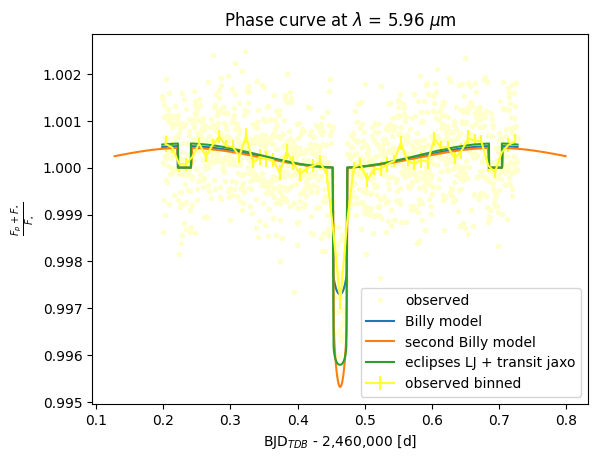

In [ ]:
fig, ax = plt.subplots()
plt.plot(observed_time, observed_pc, '.', c=(1, 1, 0.8), label='observed')
plt.errorbar(observed_binned[0], observed_binned[1], yerr=observed_binned[2], c=(1, 1, 0.2), label='observed binned')
ax.plot(model_time, model_pc, label='Billy model')
ax.plot(time_2, pc_2, label='second Billy model')
#ax.plot(model_time,phase_curvee, label='eclipses LJ')
ax.plot(model_time,phase_curvee + light_curve, label='eclipses LJ + transit jaxo')
#plt.plot(model_time,light_curve+1, label='transit jaxo')
ax.set_title(rf'Phase curve at $\lambda$ = {lamb} $\mu$m')
ax.legend()
ax.set_xlabel(r'BJD$_{TDB}$ - 2,460,000 [d]')
ax.set_ylabel(r'$\frac{F_p + F_{\star}}{F_{\star}}$')
plt.show()

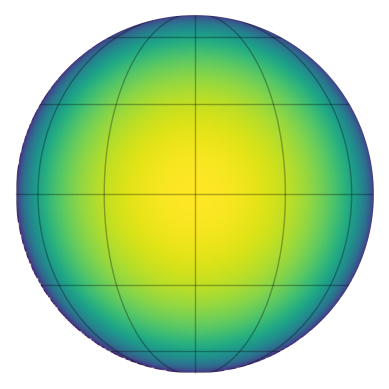

In [ ]:
m = Surface(u=uu)
show_surface(m)

In [ ]:
#print(orbit.relative_position(model_time))
x = orbit.relative_position(model_time)[0]
y = orbit.relative_position(model_time)[1]
z = orbit.relative_position(model_time)[2]
#print(surface_light_curve(m, P, x, y, z))
np.random.seed(30)
y = Ylm.from_dense(np.random.rand(20))
system2 = SurfaceSystem(star, m).add_body(planet, m)
print(starry_lc(system2)(model_time))


[[1. 1.]
 [1. 1.]
 [1. 1.]
 ...
 [1. 1.]
 [1. 1.]
 [1. 1.]]


[0 0 0 ... 0 0 0]


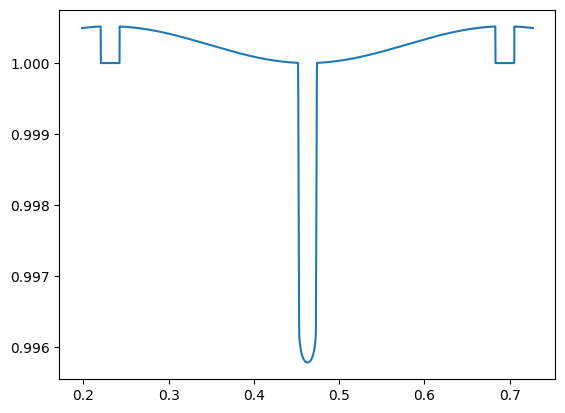

In [ ]:
eclipses = starry_lc(system2)(model_time)[:,1]
eclipses = eclipses/np.max(eclipses)
transit = starry_lc(system2)(model_time)[:,0]

in_eclipse = ~np.array(eclipses, dtype='int')+2
print(in_eclipse)

def phase_planet(t,P,t0=0):
    """
    Determines the phase of a planet at a given time.

    :param t: the time (in days)
    :type t: float

    :param P: the orbital period (in days)
    :type P: float

    :param t0: the reference time (in days)
    :type t0: float

    :return: phase
    :rtype: float
    """

    phase = np.sin(((t+t0)/P)*2*np.pi - np.pi/2)/2+0.5 # equation 15
    return phase

curve = (L/L_star)*phase_planet(model_time,P)*(R/R_star)**2 * (-1*in_eclipse+1) 
full_pc = curve + transit
#full_pc = full_pc/np.max(full_pc)

plt.figure()
#plt.plot(model_time, transit)
#plt.plot(model_time, eclipses)
#plt.plot(model_time, (~np.array(eclipses, dtype='int'))+2)
plt.plot(model_time, full_pc)
#plt.plot(model_time, (eclipses+transit)/np.max(eclipses+transit))
plt.show()

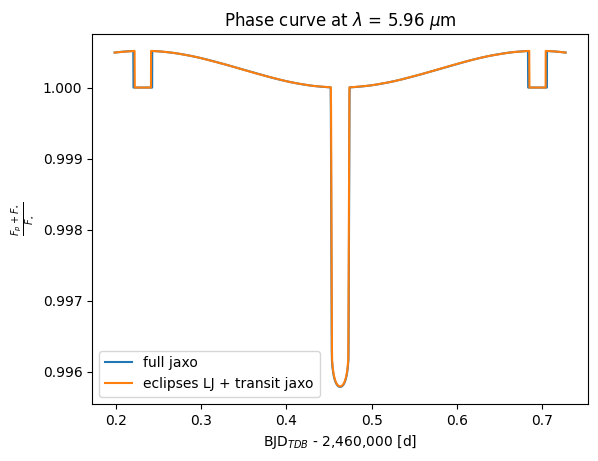

In [ ]:
fig, ax = plt.subplots()
#ax.plot(model_time,phase_curvee, label='eclipses LJ')
#ax.plot(model_time, curve)
ax.plot(model_time, full_pc, label='full jaxo')
#ax.plot(model_time, transit)
#ax.plot(model_time, light_curve+1, label='transit jaxo')
ax.plot(model_time,phase_curvee + light_curve, label='eclipses LJ + transit jaxo')
ax.set_title(rf'Phase curve at $\lambda$ = {lamb} $\mu$m')
ax.legend()
ax.set_xlabel(r'BJD$_{TDB}$ - 2,460,000 [d]')
ax.set_ylabel(r'$\frac{F_p + F_{\star}}{F_{\star}}$')
plt.show()